In [1]:
# imports
import sys
import os
import pickle
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)
from functions_EDX import *

from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

import tifffile as tif
import pacmap

In [2]:
# sub-routine to get file names
def get_file_paths(spectrum_folder):
    file_names = []
    tmp = os.listdir(spectrum_folder)
    for filename in tmp:
        if filename.endswith('.npz'):
            file_names.append(filename)
    
    file_names = sorted(file_names)
    files = [os.path.join(spectrum_folder,file_name) for file_name in file_names]
    return files

### Load data

In [3]:
supp_file_path = '/Users/AJ/Desktop/PACMAP_RESULTS/Identify2/pacpam_instance/pacmap_panc_euc_20percent_SavedTree20240209-105636.npz'
abundance_maps = np.load(supp_file_path)['abundance_maps']
abundance_maps = abundance_maps / np.max(abundance_maps) # Scale to have max coefficient = 1
colors = np.load(supp_file_path)['colors']
colors[0] = [0,0,0]

# choose a tile
tile_idx = 8

# location of SAM masks
masks_path = '/Users/AJ/Desktop/work/PostDoc_UMCG/work/analysis/EDX_Project/primary_data/main_mosaic_6by5/SAM_masks/'

# get HAADF img
spectrum_folder = '/Volumes/Microscopy3/EDX_data/Identify/main_mosaic_6by5/NPZ/'
files = get_file_paths(spectrum_folder)
haadf = rebin_XY(np.load(files[tile_idx])['haadf'],1024)

### Load the sam masks for the selected tile

In [4]:
# Get the masks
file = open(os.path.join(masks_path,'tile_%02d.pkl' % tile_idx),'rb')
masks = pickle.load(file)

### Show the masks over the Haadf

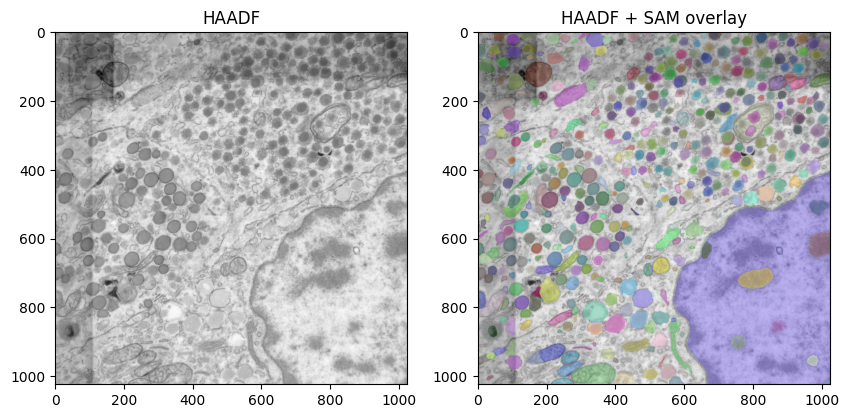

In [5]:
%matplotlib inline
f,ax= plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(haadf,cmap='gray_r')
ax[1].imshow(haadf,cmap='gray_r')
ax[1].imshow(show_anns(masks,display=False))
ax[0].set_title('HAADF')
ax[1].set_title('HAADF + SAM overlay')
#plt.axis('off')
plt.show() 

### Abundance map composite image (from Figure 3)

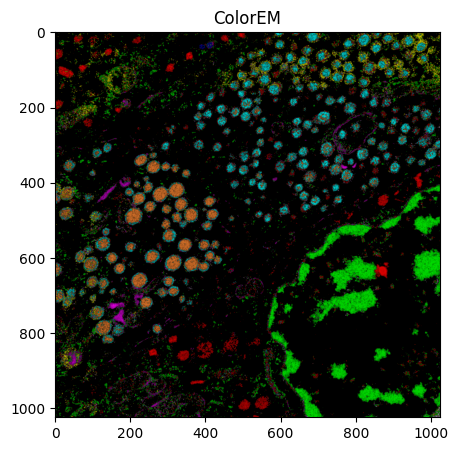

In [6]:
# Abundance for a single tile
abundance_tile = abundance_maps[:,:,:,tile_idx]

rgb_image = np.zeros((3,abundance_tile.shape[1],abundance_tile.shape[2]))

for x in range(rgb_image.shape[1]):
    for y in range(rgb_image.shape[2]):
        idx = np.argmax(abundance_tile[:,x,y])
        rgb_image[0,x,y] = colors[idx][0]*abundance_tile[idx,x,y] if idx!=0 else colors[idx][0]*(1-abundance_tile[idx,x,y])
        rgb_image[1,x,y] = colors[idx][1]*abundance_tile[idx,x,y] if idx!=0 else colors[idx][1]*(1-abundance_tile[idx,x,y])
        rgb_image[2,x,y] = colors[idx][2]*abundance_tile[idx,x,y] if idx!=0 else colors[idx][2]*(1-abundance_tile[idx,x,y])

f,ax = plt.subplots(figsize=(5,5))
ax.imshow((rgb_image.transpose(1,2,0)*255).astype('uint8'))
ax.set_title('ColorEM')
plt.show()

### SAM/EDX

In [9]:
# compute
sam_edx_overlay,_ = show_anns_EDX(masks,abundance_tile,colors,
                                  display=False,alpha=0.35,
                                  min_purity=0,
                                  ignore_background=True)


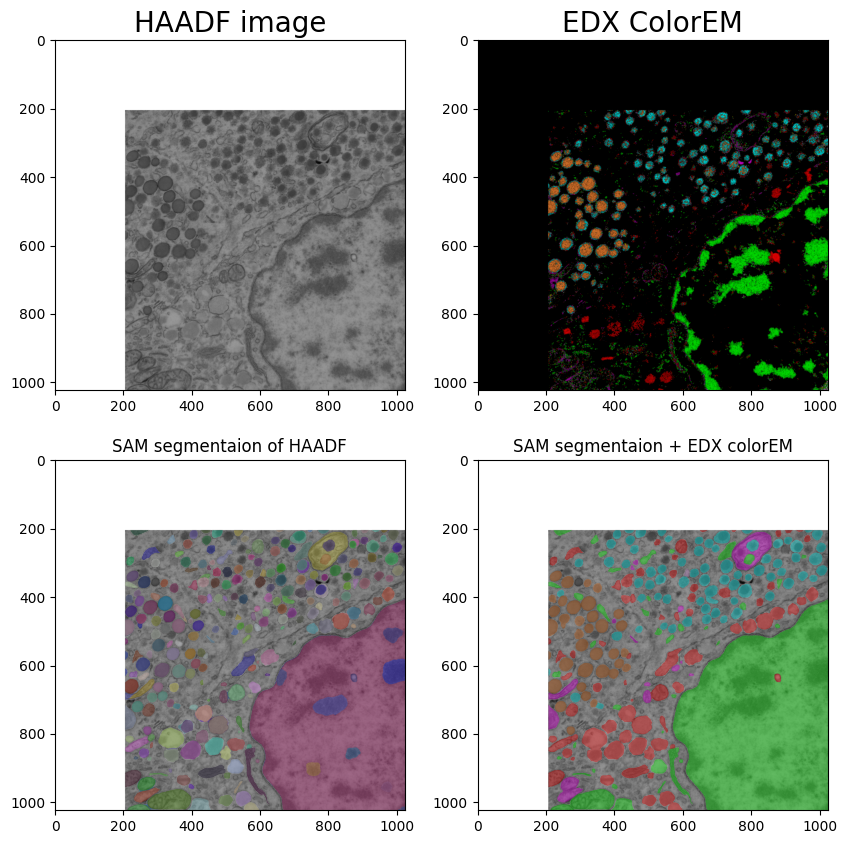

In [10]:
# parts of the image that are stitched over
overlap_mask = ~overlap_corr(tile_idx=tile_idx,xy_dim=1024,rows=6,cols=5,overlap_ratio=0.2)
overlap_mask_3d =np.repeat(overlap_mask[:, :, np.newaxis], 3, axis=2)
overlap_mask_4d =np.repeat(overlap_mask[:, :, np.newaxis], 4, axis=2)

f,ax = plt.subplots(2,2,figsize=(10,10))

ax[0][0].imshow(haadf*overlap_mask,cmap='gray_r')
ax[0][0].set_title('HAADF image',fontsize=20)

ax[0][1].imshow((rgb_image.transpose(1,2,0)*255).astype('uint8')*overlap_mask_3d)
ax[0][1].set_title('EDX ColorEM',fontsize=20)

ax[1][0].imshow(haadf*overlap_mask,cmap='gray_r')
ax[1][0].imshow(show_anns(masks,display=False)*overlap_mask_4d)
ax[1][0].set_title('SAM segmentaion of HAADF',fontsize=12)


ax[1][1].imshow(haadf*overlap_mask,cmap='gray_r')
ax[1][1].imshow(sam_edx_overlay*overlap_mask_4d)
ax[1][1].set_title('SAM segmentaion + EDX colorEM',fontsize=12)

plt.show()